## *Tutorial for the ESPIDAM Practical*

The aim of this tutorial is to investigate what the influence of network structure is on the spread of an SIR epidemic. We will look at various types of networks and and agent based SIR model running on these networks. We will compare network structure in terms of degree distribution and centrality measures. Epidemic outcome will be measured as final size, duration, and peak prevalence of the outbreak. 

First we need to set up a directory structure to store data, output, and figures.

In [1]:
#Navigate to the directory containing this file
    cd(@__DIR__)

# Create directories if they don't exist
    if !isdir("data")
        mkdir("data")
    end
    if !isdir("figures")
        mkdir("figures")
    end
    if !isdir("output")
        mkdir("output")
    end

Then we activate the current directory as the environment for Pkg. We import the packages we will need to run the model.

In [2]:
 # Import the Pkg module, activate the current directory as the environment for Pkg, instantiate the environment
    using Pkg
    Pkg.activate(@__DIR__)
    Pkg.instantiate()

  # Import the necessary packages
    using Agents, Graphs, Random, Plots, DataFrames, CSV, Statistics, Distributions

  Activating project at `c:\Users\leost\julia-workspace\espidam-tutorial-2025`


A degree distribution to be used with the configuration model is read from a csv file. The file needs to have a number of rows that equals the population size of the network. For every node an integer degree is given. 

In [3]:
 
    # Read in deg_dist.csv to use for the random_configuration_model
    degrees = CSV.read("deg_dist.csv", DataFrame, header=false)

Row,Column1
,Int64
1,6
2,16
3,9
4,5
5,3
6,5
7,3
8,5
9,3


Next, the model is defined. The code is provided in various source files that are included. In the source file create_graph.jl a network is set up with a given number of nodes (default size 1000) and a given network structure. Then the structure of the agents is defined. An agent is characterized by its infection status (susceptible, infected, or recovered), by its infection age (time since infection), and by risk category (low or high). The source file initialize.jl describes the initialization procedure of the model, and the agent_step.jl describes events that are performed per time step. Then, in model_step() the numbers of individuals in disease states are summed up. 

In [4]:
begin
    include("src/create_graph.jl")

    # Agent creation: agents of type Person and properties status, days_infected and risk
    @agent struct Person(GraphAgent)
        status::Symbol = :S #((S)usceptible, (I)nfected, (R)ecovered)
        days_infected::Int = 0 # number of days since infection
        risk::Symbol = :high # something to differentiate agents (here, high and low risk)
    end

    include("src/initialize.jl")
    include("src/agent_step.jl")

    # Model step: keep track of the infection numbers
    function model_step!(model::ABM)
        model.susceptible_count = sum([model[i].status == :S for i in 1:nv(model.graph)])
        model.infected_count = sum([model[i].status == :I for i in 1:nv(model.graph)])
        model.recovered_count = sum([model[i].status == :R for i in 1:nv(model.graph)])
    end
end

model_step! (generic function with 1 method)

Now let's start with setting up the model for our investigation. In the initialization function, we can choose what network type we want to use, where in the network the infection is seeded, what proportion of the population is high risk, and what the mean degree of the network is.

In [5]:
# Initialization: initialize the model with the chosen parameters: network_type, patient_zero, high_risk, mean_degree
model = initialize(; network_type=:preferentialattachment, patient_zero=:random, mean_degree=2)

StandardABM with 1000 agents of type Person
 agents container: Dict
 space: GraphSpace with 1000 positions and 999 edges
 scheduler: fastest
 properties: days_to_recovered, trans_prob, mean_degree, high_risk, susceptible_count, fraction_high_risk, infected_count, recovered_count, graph, dispersion, n_nodes, patient_zero, network_type

The constructed network can be analyzed, the code for this analysis is included in analyze_graph.jl. Various centrality measures are calculated for all nodes of the network. Furthermore the network density and clustering and the degree distribution are computed and written into a csv file. 

In [6]:
include("src/analyze_graph.jl")

# Analyze the graph, output the results to a CSV file
graph_measures = analyze_graph(model.graph)
CSV.write("data/graph_keyfig_$(model.network_type)_mdeg_$(model.mean_degree)_nn_$(model.n_nodes)_disp_$(model.dispersion)_pat0_$(model.patient_zero)_hirisk_$(model.high_risk)_hr_frac_$(model.fraction_high_risk)_trans_$(model.trans_prob).csv", graph_measures)


"data/graph_keyfig_preferentialattachment_mdeg_2_nn_1000_disp_0.1_pat0_random_hirisk_random_hr_frac_0.1_trans_0.1.csv"

Various plotting functions are encoded in plotting.jl. For example, we can generate a plot of the degree distribution as a histogram. 

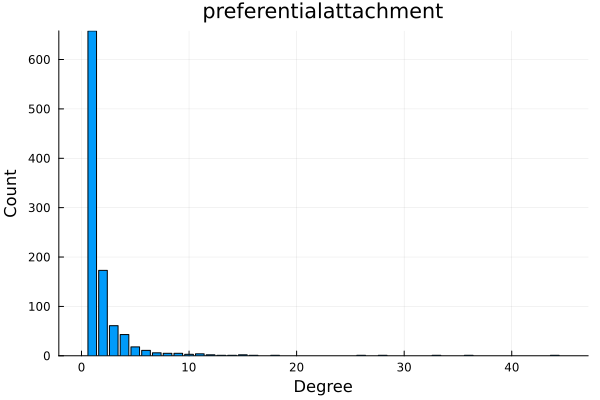

"c:\\Users\\leost\\julia-workspace\\espidam-tutorial-2025\\figures\\plotdegdist_preferentialattachment_mdeg_2_nn_1000_disp_0.1_pat0_random_hirisk_random_hr_frac_0.1_trans_0.1.pdf"

In [7]:
include("src/plotting.jl")

#plot_degree_distribution(graph_measures)
plotdegdist = plot_degree_distribution(graph_measures;model.network_type)
display(plotdegdist)
savefig(plotdegdist, "figures/plotdegdist_$(model.network_type)_mdeg_$(model.mean_degree)_nn_$(model.n_nodes)_disp_$(model.dispersion)_pat0_$(model.patient_zero)_hirisk_$(model.high_risk)_hr_frac_$(model.fraction_high_risk)_trans_$(model.trans_prob).pdf")


In [8]:
# specify "adata" (agent data to collect) and "mdata" (model data to collect)
adata = [:status]
mdata = [:susceptible_count, :infected_count, :recovered_count]

adf, mdf = run!(model, 100; adata, mdata)

(101000×3 DataFrame
    Row │ time   id     status 
        │ Int64  Int64  Symbol 
────────┼──────────────────────
      1 │     0      1  S
      2 │     0      2  S
      3 │     0      3  S
      4 │     0      4  S
      5 │     0      5  S
      6 │     0      6  S
      7 │     0      7  S
      8 │     0      8  S
   ⋮    │   ⋮      ⋮      ⋮
 100994 │   100    994  S
 100995 │   100    995  S
 100996 │   100    996  S
 100997 │   100    997  S
 100998 │   100    998  S
 100999 │   100    999  S
 101000 │   100   1000  S
            100985 rows omitted, 101×4 DataFrame
 Row │ time   susceptible_count  infected_count  recovered_count 
     │ Int64  Int64              Int64           Int64           
─────┼───────────────────────────────────────────────────────────
   1 │     0               1000               1                0
   2 │     1                999               1                0
   3 │     2                997               3                0
   4 │     3            

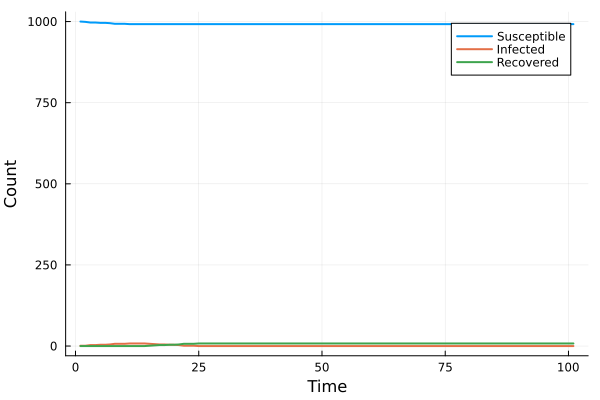

"c:\\Users\\leost\\julia-workspace\\espidam-tutorial-2025\\figures\\plotdynamics_preferentialattachment_mdeg_2_nn_1000_disp_0.1_pat0_random_hirisk_random_hr_frac_0.1_trans_0.1.pdf"

In [9]:
plotdynamics = plot_epidemic_trajectories(mdf)
display(plotdynamics)
savefig(plotdynamics, "figures/plotdynamics_$(model.network_type)_mdeg_$(model.mean_degree)_nn_$(model.n_nodes)_disp_$(model.dispersion)_pat0_$(model.patient_zero)_hirisk_$(model.high_risk)_hr_frac_$(model.fraction_high_risk)_trans_$(model.trans_prob).pdf")


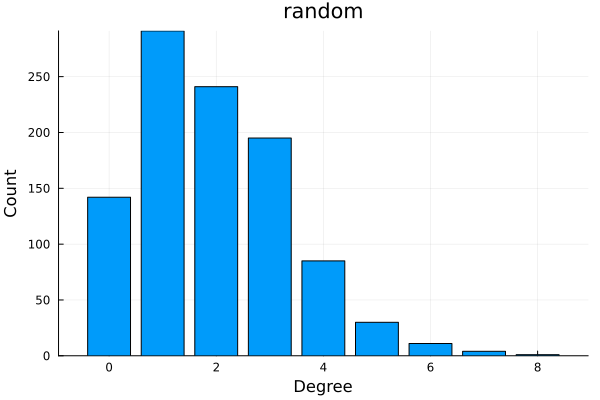

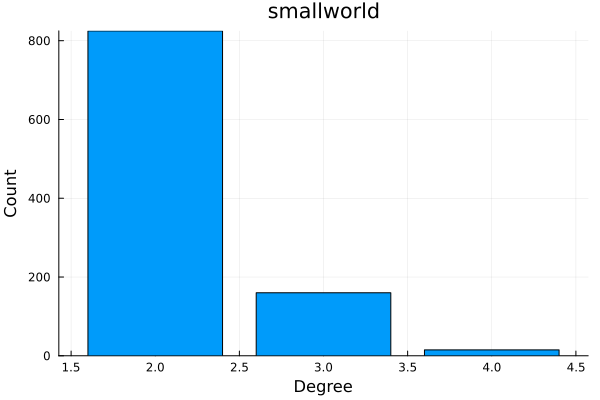

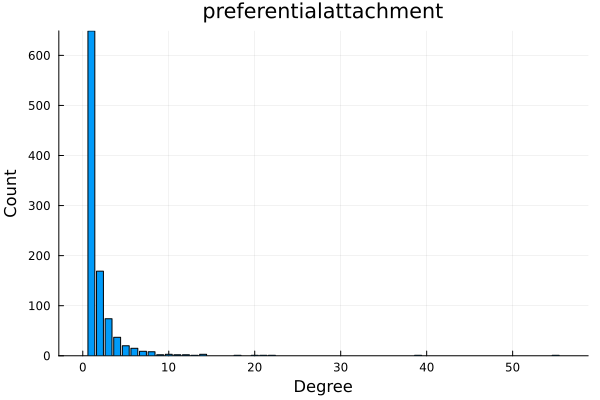

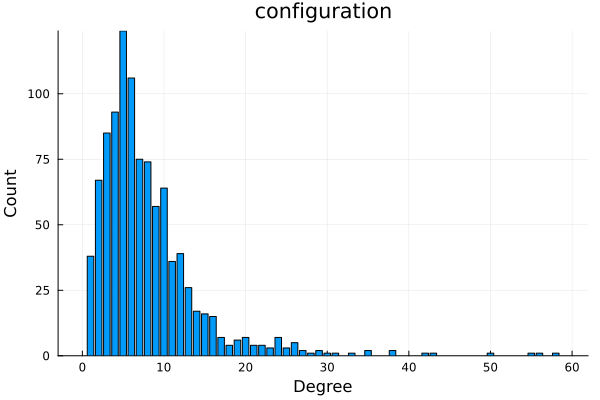

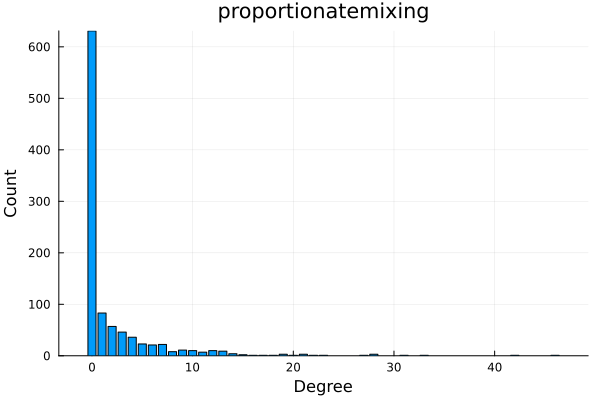

"c:\\Users\\leost\\julia-workspace\\espidam-tutorial-2025\\figures\\plotdegdist_proportionatemixing_mdeg_2_nn_1000_disp_0.1_pat0_random_hirisk_random_hr_frac_0.1_trans_0.1.pdf"

In [10]:
# for easier comparison, we plot the same scenario for all network types (initializes and runs model)
plot_single_run(; network_type=:random, mean_degree=2)
plot_single_run(; network_type=:smallworld, mean_degree=2)
plot_single_run(; network_type=:preferentialattachment, mean_degree=2)
plot_single_run(; network_type=:configuration, mean_degree=2)
plot_single_run(; network_type=:proportionatemixing, mean_degree=2)

In [11]:
include("src/run_simulations.jl")

run_simulations

$x=a*y$

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


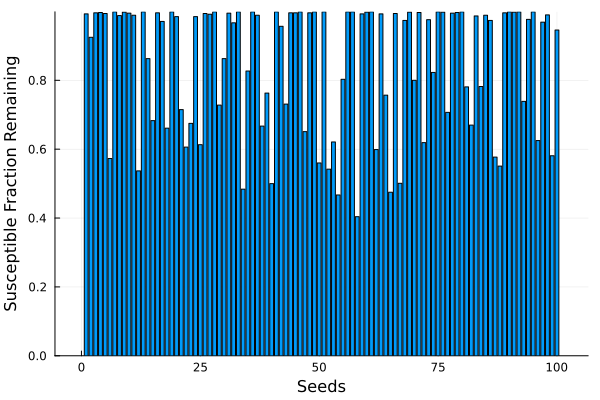

In [12]:
# Run the simulation multiple times with different seeds (100 times), output results to file and plot
run_and_plot(; plot_type=:sfr, network_type=:preferentialattachment, patient_zero=:maxdegree, mean_degree=2)